# Demo Notebook Demonstrating How to Test for Component/CPW Overlap

This tutorial notebook demonstrates how to use the QDesign_Check class to test for overlap and/or collisions between componenets in a design. Let's start by importing the relevant modules and opening up the GUI:

In [1]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.qlibrary.qubits.transmon_pocket_6 import TransmonPocket6
design = metal.designs.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True
design.chips.main

{'material': 'silicon',
 'layer_start': '0',
 'layer_end': '2048',
 'size': {'center_x': '0.0mm',
  'center_y': '0.0mm',
  'center_z': '0.0mm',
  'size_x': '9mm',
  'size_y': '6mm',
  'size_z': '-750um',
  'sample_holder_top': '890um',
  'sample_holder_bottom': '1650um'}}

## Design #1: CPW/Qubit Collision

Let's create a design with three qubits in a straight line. Then we'll connect the outer two qubits with a CPW which (intentionally) intersects the middle qubit. 

In [2]:
Q1 = TransmonPocket6(design,'Q1',options =  dict(
    pos_x='-2mm',
    pos_y='0mm',
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=1, loc_H=-1, pad_width = '100um', pad_gap = '50um'),
        bus_01 = dict(loc_W=1, loc_H=1, pad_width = '100um', pad_gap = '50um'),       
    ))
                    )

Q2 = TransmonPocket6(design,'Q2',options =  dict(
    pos_x='2mm',
    pos_y='0mm',
    orientation=0,
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=-1, loc_H=-1, pad_width = '100um', pad_gap = '50um'),
        bus_01 = dict(loc_W=-1, loc_H=1, pad_width = '100um', pad_gap = '50um'),       
    ))
                    )

Q3 = TransmonPocket6(design,'Q3',options =  dict(
    pos_x='0mm',
    pos_y='0mm',
    orientation=0,
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=-1, loc_H=-1, pad_width = '100um', pad_gap = '50um'),
        bus_01 = dict(loc_W=-1, loc_H=1, pad_width = '100um', pad_gap = '50um'),       
    ))
                    )

gui.rebuild()
gui.autoscale()

In [3]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

bus1 = RoutePathfinder(design, 'coupler1', Dict(
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='readout'),
            end_pin=Dict(component='Q2', pin='readout')), ))

gui.rebuild()
gui.autoscale()

Let's look at a screenshot to see that there is in fact a CPW/qubit collision:

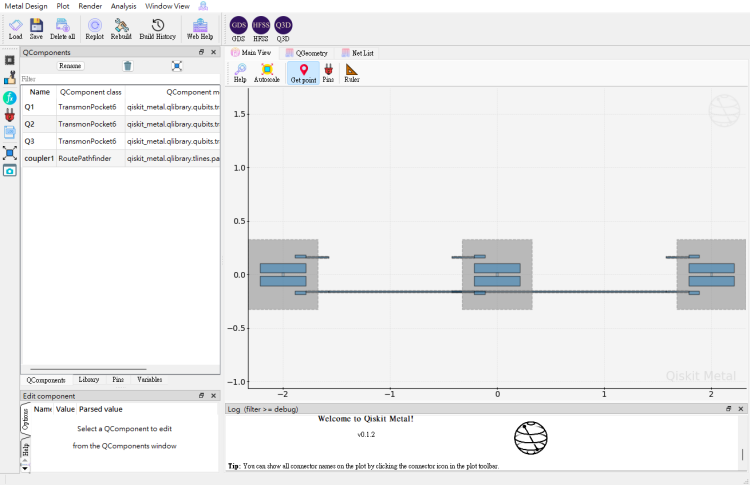

In [4]:
gui.screenshot()

Indeed we can see the CPW being routed straight through the middle qubit. We can use the "overlap_tester" function in the QDesign_Check class to verify that this is caught:

Let's now import the QDesign_Check class, which contains several useful functions to test for overlap and collisions among design components:

In [5]:
from qiskit_metal.qlibrary.core.design_check import QDesignCheck
a_tester = QDesignCheck(design)

ModuleNotFoundError: No module named 'qiskit_metal.qlibrary.core.design_check'

And now we'll test the design for any overlap or collision errors:

In [ ]:
a_tester.overlap_tester()

This function tells us that there is a collision between component 3 (the middle qubit) and component 4 (the CPW.)

## Design #2: CPW/CPW Collision

Now let's modify the existing design to create a scenario where two CPW resonators intersect with one another. We can do this by shifting the middle qubit up and adding another qubit below it:

In [ ]:
Q3.options.pos_y = '2.0 mm'
Q3.options.orientation = '90'

In [6]:
Q4 = TransmonPocket6(design,'Q4',options =  dict(
    pos_x='0mm',
    pos_y='-2mm',
    orientation=270,
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=-1, loc_H=-1, pad_width = '100um', pad_gap = '50um'),
        bus_01 = dict(loc_W=-1, loc_H=1, pad_width = '100um', pad_gap = '50um'),       
    ))
                    )

gui.rebuild()
gui.autoscale()

In [7]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

bus1 = RouteStraight(design, 'coupler2', Dict(
        pin_inputs=Dict(
            start_pin=Dict(component='Q3', pin='readout'),
            end_pin=Dict(component='Q4', pin='readout')), ))

gui.rebuild()
gui.autoscale()

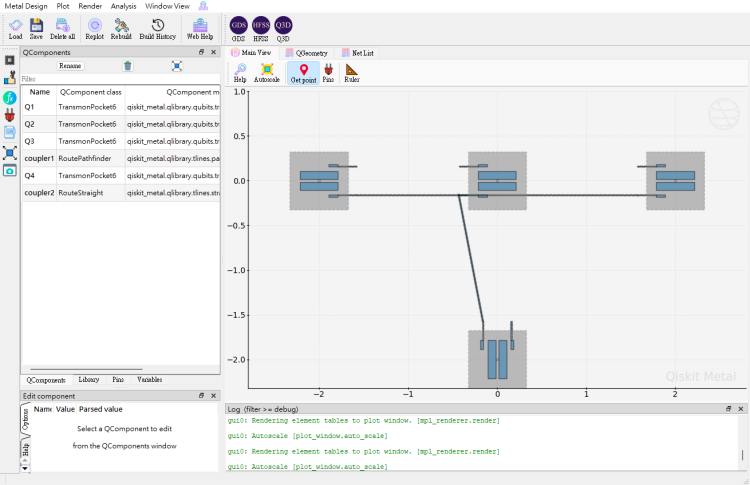

In [8]:
gui.screenshot()

Indeed we can see that the two CPWs are crossing one another. Let's see if the overlap_tester catches this:

In [9]:
a_tester.update_design(design)
a_tester.overlap_tester()

NameError: name 'a_tester' is not defined

We see that the collision is detected between component 4 (the horizontal CPW) and component 5 (the vertical CPW). 

## Design #3: Qubit/Qubit Overlap

Let's modify the existing design to remove the CPWs and move one of the qubits so that it's partially overlapping with another:

In [ ]:
design.delete_component('coupler1')
design.delete_component('coupler2')
Q4.options.pos_y = '1.5 mm'
gui.rebuild()
gui.autoscale()

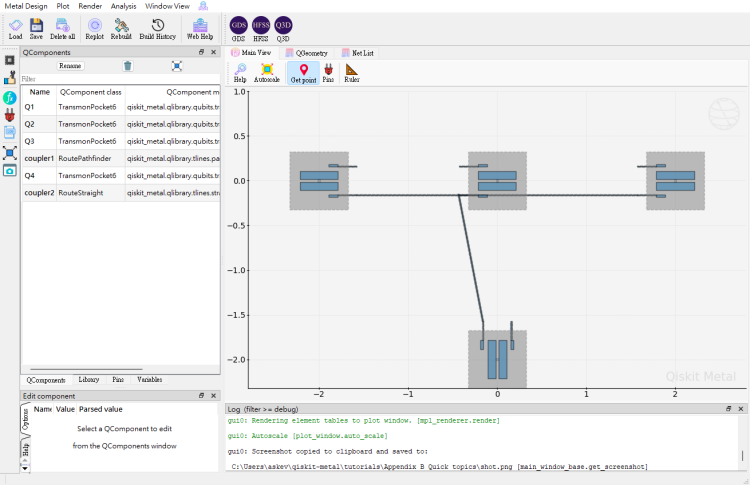

In [10]:
gui.screenshot()

In [11]:
a_tester.update_design(design)
a_tester.overlap_tester()

NameError: name 'a_tester' is not defined

Here we see that program correctly identified a collision between qubits 3 and 5. 